In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'

from astropy.io import fits
import numpy as np
import aplpy
from astropy.wcs import WCS
from pycupid import clumpfind, fellwalker, reinhold, gaussclumps

# fits_name = "/Users/naoj306/Desktop/DB/FGN/FGN_03100+0000_2x2_13CO_v1.00_cube.fits"
fits_name = "/Users/naoj306/Desktop/DB/SFP/AquilaRift_12CO_21.7arcsec_vel0.1_sph_v1.0.fits"

hdu = fits.open(fits_name)[0]
w = WCS(hdu.header)

In [150]:
def v2ch(v, w): # v(km/s)をchに変える
    x_tempo, y_tempo, v_tempo   = w.wcs_pix2world(0, 0, 0, 0)
    x_ch, y_ch, v_ch   = w.wcs_world2pix(x_tempo, y_tempo, v*1000.0, 0)
    v_ch = int(round(float(v_ch), 0))
    return v_ch

def del_header_key(header, keys): # headerのkeyを消す
    import copy
    h = copy.deepcopy(header)
    for k in keys:
        try:
            del h[k]
        except:
            pass
    return h
def make_new_hdu_integ(hdu, v_start_wcs, v_end_wcs, w):
    # 積分強度のhduを作る
    data = hdu.data
    header = hdu.header
    start_ch, end_ch = v2ch(v_start_wcs, w), v2ch(v_end_wcs, w)
    new_data = np.nansum(data[start_ch:end_ch+1], axis=0)*header["CDELT3"]/1000.0
    header = del_header_key(header, ["CRVAL3", "CRPIX3", "CRVAL3", "CDELT3", "CUNIT3", "CTYPE3", "CROTA3", "NAXIS3"])
    header["NAXIS"] = 2
    new_hdu = fits.PrimaryHDU(new_data, header)
    return new_hdu


[85.18148803710938, 20]
No clumps found at threshold: 85.18148803710938
Clumps found with threshold: 20


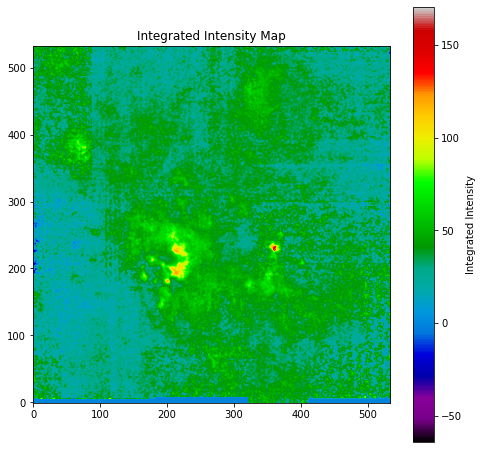

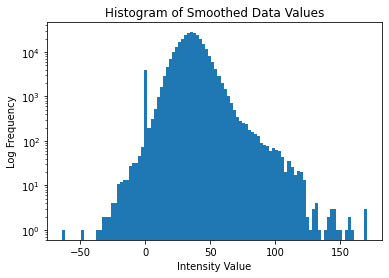

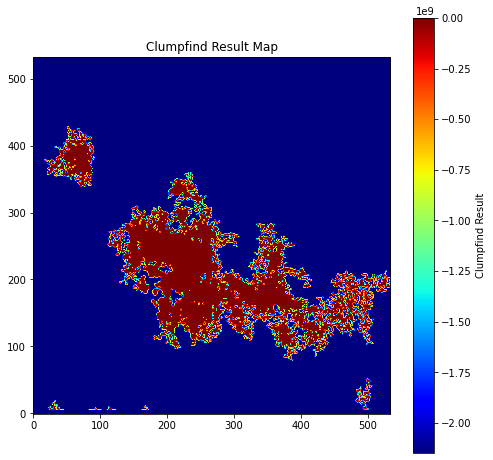

In [151]:
# Integrate the FITS data
integ_hdu = make_new_hdu_integ(hdu, -25.0, 49.0, w)
max_value = np.nanmax(integ_hdu.data)

# Attempt to find clumps with a dynamic threshold
thresholds = [max_value / 2, 20]  
print(thresholds)
clump_found = False

for threshold in thresholds:
    cf_result = clumpfind(integ_hdu.data, threshold)
    if cf_result is not None:
        cf = cf_result.astype("float32")
        cf_2 = cf.reshape(cf.shape[::-1]).T
        clump_found = True
        print(f"Clumps found with threshold: {threshold}")
        break
    else:
        print(f"No clumps found at threshold: {threshold}")

# Plot the integrated intensity map
fig, ax = plt.subplots(figsize=(8, 8))
img = ax.imshow(integ_hdu.data, cmap='nipy_spectral', origin='lower')
fig.colorbar(img, ax=ax, label='Integrated Intensity')
ax.set_title('Integrated Intensity Map')
plt.show()

# Histogram of smoothed data
plt.figure()
plt.hist(integ_hdu.data.flatten(), bins=100, log=True)
plt.title('Histogram of Smoothed Data Values')
plt.xlabel('Intensity Value')
plt.ylabel('Log Frequency')
plt.show()

# Plot clump detection result if clumps were found
if clump_found:
    fig, ax = plt.subplots(figsize=(8, 8))
    img = ax.imshow(cf_2, cmap='jet', origin='lower')
    fig.colorbar(img, ax=ax, label='Clumpfind Result')
    ax.set_title('Clumpfind Result Map')
    plt.show()
else:
    print("Unable to find any clumps with the given thresholds.")


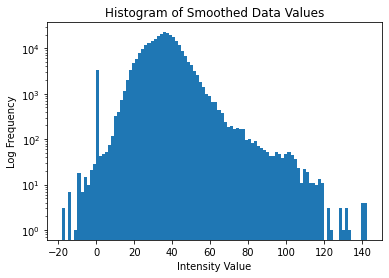

Threshold is 19.972657012939454


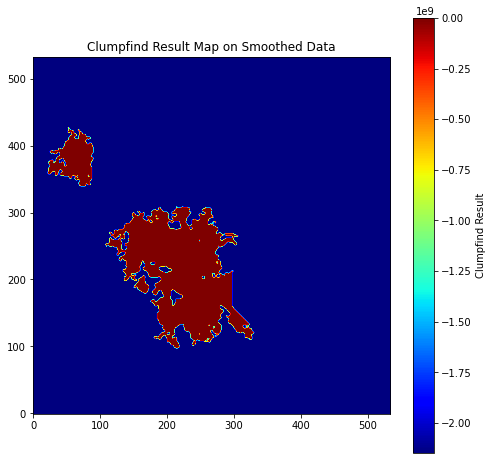

In [152]:
from scipy.ndimage import median_filter

# Apply median filtering
smoothed_data = median_filter(integ_hdu.data, size=5)  # Adjust size as needed

# Histogram of smoothed data
plt.figure()
plt.hist(smoothed_data.flatten(), bins=100, log=True)
plt.title('Histogram of Smoothed Data Values')
plt.xlabel('Intensity Value')
plt.ylabel('Log Frequency')
plt.show()

# Re-run clumpfind on the smoothed data with adjusted thresholds
threshold_value = np.percentile(smoothed_data, 5)  # 选择整个数据中大于最低强度标准的那个为threshold
print(f"Threshold is {threshold_value}")

cf_result = clumpfind(smoothed_data, threshold_value)
if cf_result is not None:
    cf = cf_result.astype("float32")
    cf_2 = cf.reshape(cf.shape[::-1]).T

    # Plot results
    fig, ax = plt.subplots(figsize=(8, 8))
    img = ax.imshow(cf_2, cmap='jet', origin='lower')
    fig.colorbar(img, ax=ax, label='Clumpfind Result')
    ax.set_title('Clumpfind Result Map on Smoothed Data')
    plt.show()
else:
    print("No clumps found with the new settings.")



noise is 15


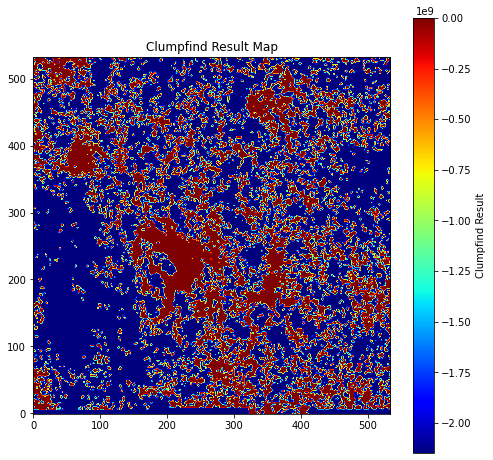

noise is 20


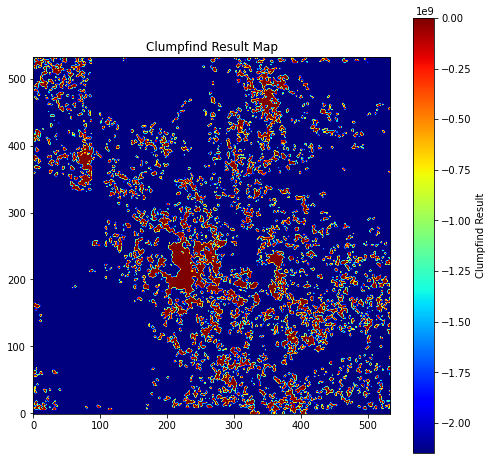

noise is 25


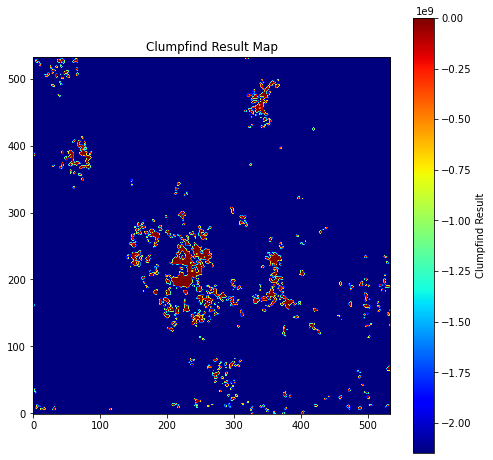

In [153]:
from pycupid import fellwalker

# Integrate the FITS data
integ_hdu = make_new_hdu_integ(hdu, -25.0, 49.0, w)
max_value = np.nanmax(integ_hdu.data)

noises = [15, 20, 25]   
for noise in noises:
    cf_result = fellwalker(integ_hdu.data, noise)
    if cf_result is not None and np.any(cf_result):
        cf = cf_result.astype("float32")
        cf_2 = cf.reshape(cf.shape[::-1]).T
    
        # Plot the results
        print(f"noise is {noise}")
        fig, ax = plt.subplots(figsize=(8, 8))
        img = ax.imshow(cf_2, cmap='jet', origin='lower')
        fig.colorbar(img, ax=ax, label='Clumpfind Result')
        ax.set_title('Clumpfind Result Map')
        plt.show()
    else:
        print("No clumps found")


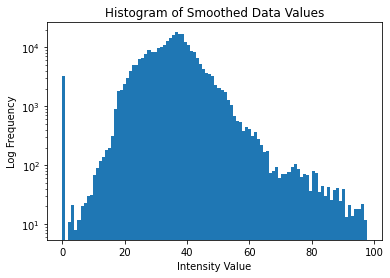

noise is 5


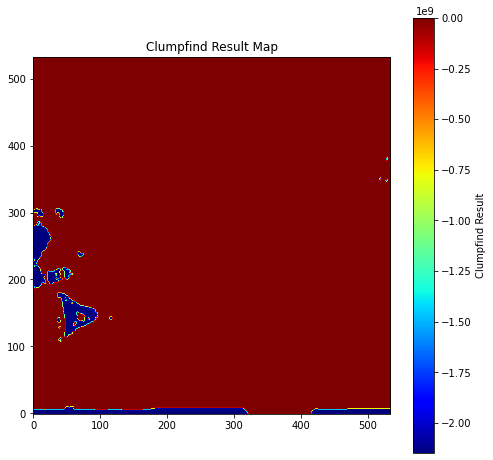

noise is 10


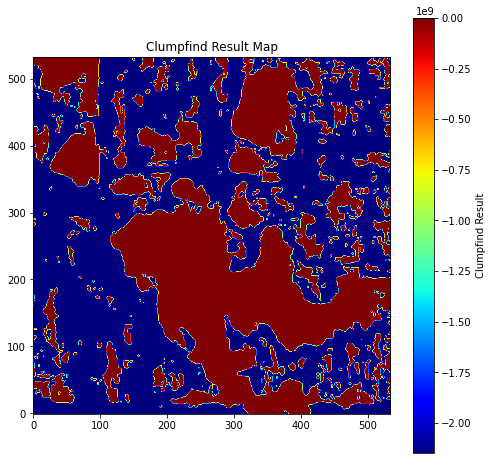

noise is 15


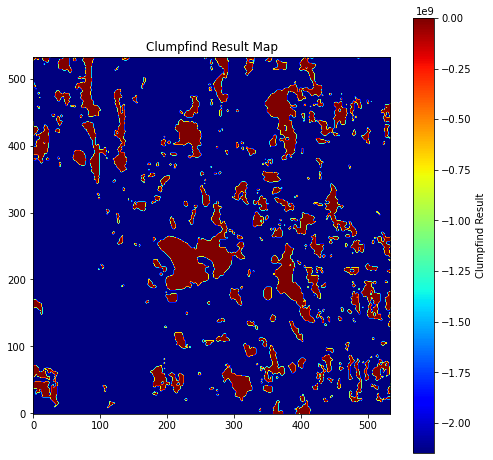

noise is 20


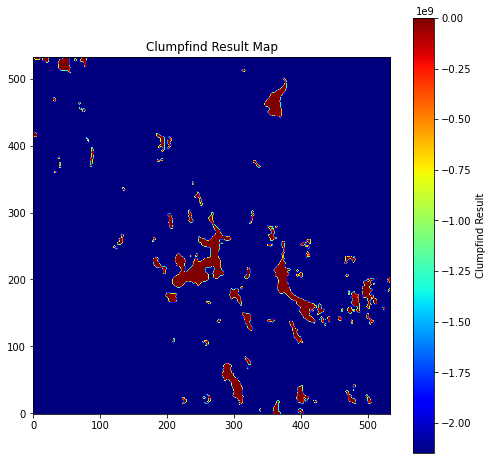

In [157]:
from pycupid import fellwalker

# Integrate the FITS data
# Apply median filtering
smoothed_data = median_filter(integ_hdu.data, size=20)  # Adjust size as needed

# Histogram of smoothed data
plt.figure()
plt.hist(smoothed_data.flatten(), bins=100, log=True)
plt.title('Histogram of Smoothed Data Values')
plt.xlabel('Intensity Value')
plt.ylabel('Log Frequency')
plt.show()

noises = [5, 10, 15, 20]   
for noise in noises:
    cf_result = fellwalker(smoothed_data, noise)
    if cf_result is not None and np.any(cf_result):
        cf = cf_result.astype("float32")
        cf_2 = cf.reshape(cf.shape[::-1]).T
    
        # Plot the results
        print(f"noise is {noise}")
        fig, ax = plt.subplots(figsize=(8, 8))
        img = ax.imshow(cf_2, cmap='jet', origin='lower')
        fig.colorbar(img, ax=ax, label='Clumpfind Result')
        ax.set_title('Clumpfind Result Map')
        plt.show()
    else:
        print("No clumps found")


RMS is 5


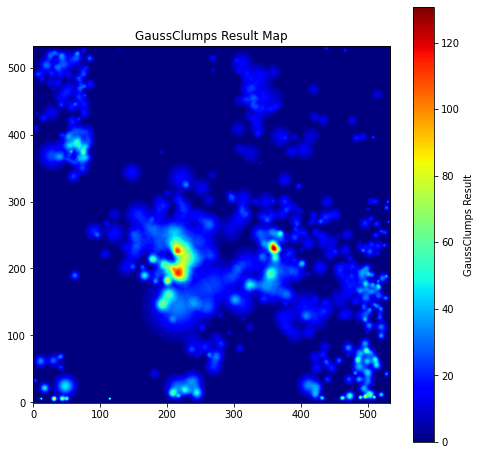

RMS is 10


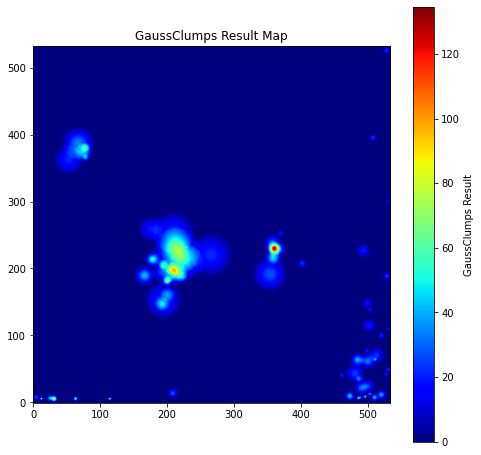

RMS is 15


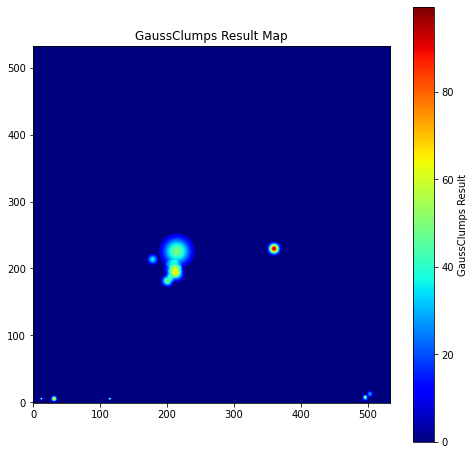

In [156]:
from pycupid import gaussclumps

rms_values = [5, 10, 15]
for rms in rms_values:
    gc_result = gaussclumps(integ_hdu.data, rms=rms)
    if gc_result is not None and np.any(gc_result):
        gc = gc_result.astype("float32")
        gc_2 = gc.reshape(gc.shape[::-1]).T
    if gc_result is not None and np.any(gc_result):
        print(f"RMS is {rms}")
        fig, ax = plt.subplots(figsize=(8, 8))
        img = ax.imshow(gc_2, cmap='jet', origin='lower')
        fig.colorbar(img, ax=ax, label='GaussClumps Result')
        ax.set_title('GaussClumps Result Map')
        plt.show()
    else:
        print("No clumps found")


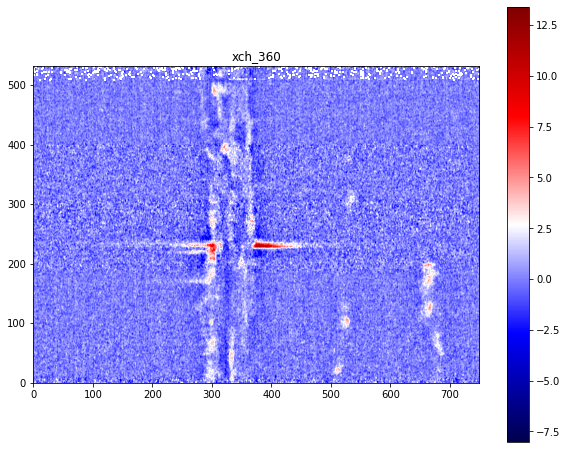

threshold = -2
No Clumps Found
threshold = -1
No Clumps Found
threshold = 0
No Clumps Found
threshold = 0.2
Number of clumps detected at threshold 0.2: 7146


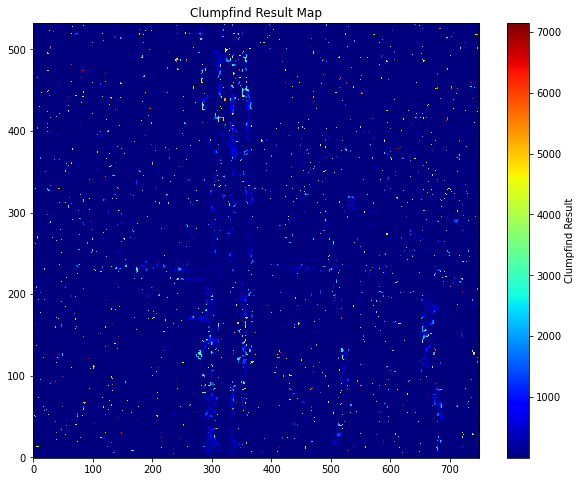

threshold = 0.4
Number of clumps detected at threshold 0.4: 2630


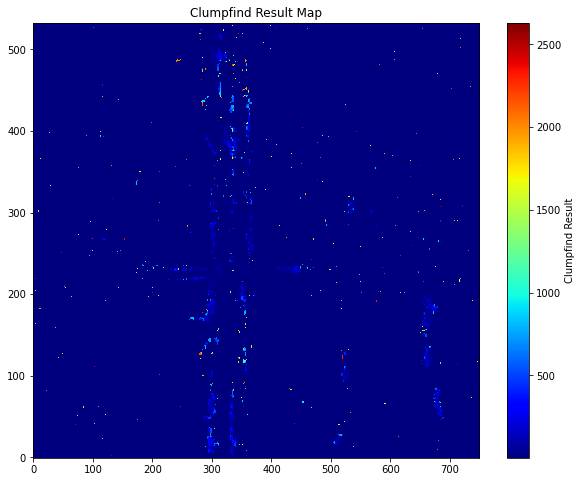

threshold = 0.6
Number of clumps detected at threshold 0.6: 688


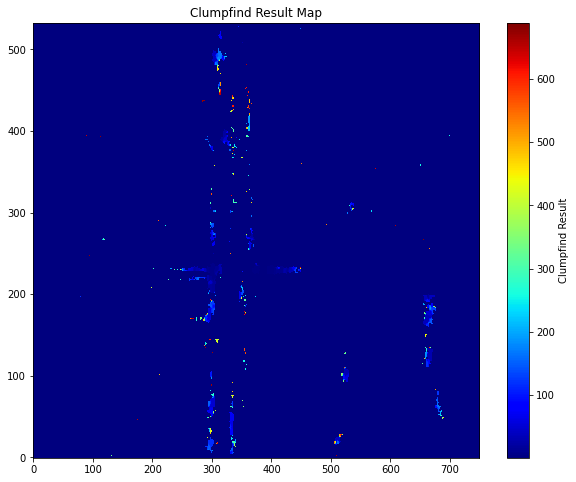

threshold = 0.8
Number of clumps detected at threshold 0.8: 239


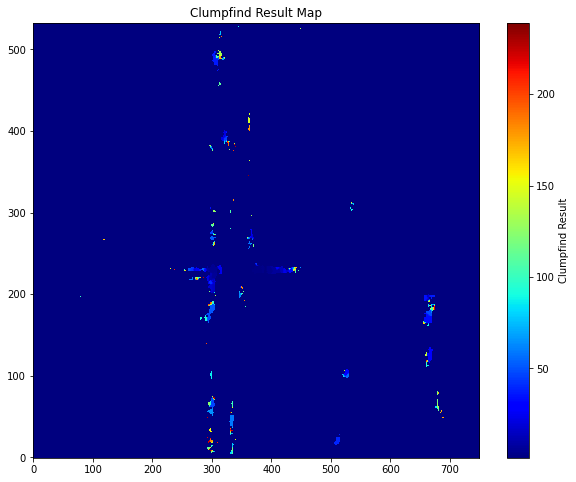

threshold = 1.0
Number of clumps detected at threshold 1.0: 112


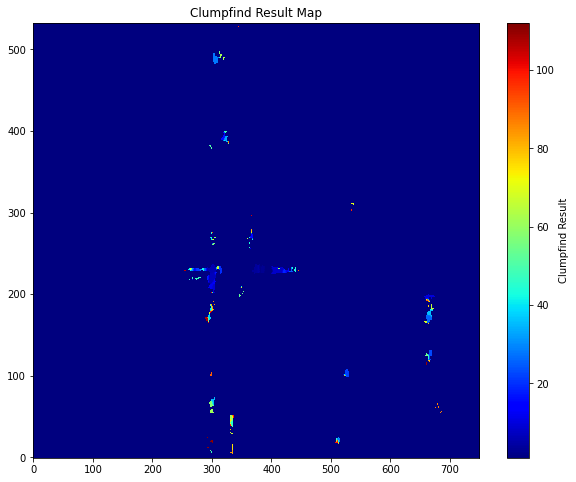

threshold = 1.2
Number of clumps detected at threshold 1.2: 54


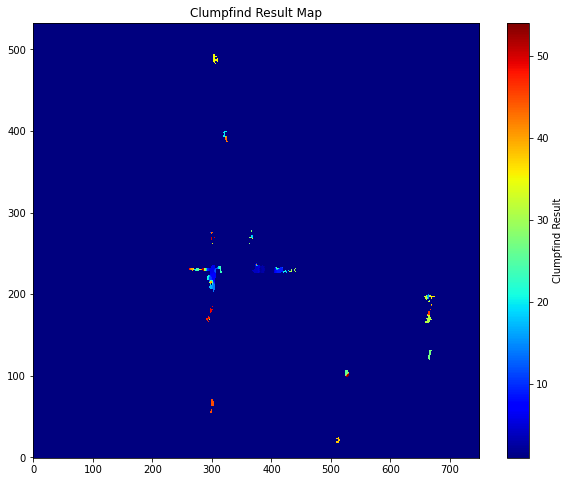

threshold = 1.4
Number of clumps detected at threshold 1.4: 27


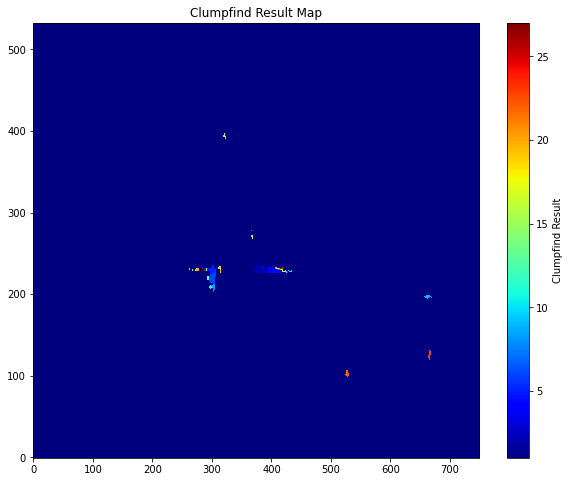

threshold = 1.6
Number of clumps detected at threshold 1.6: 18


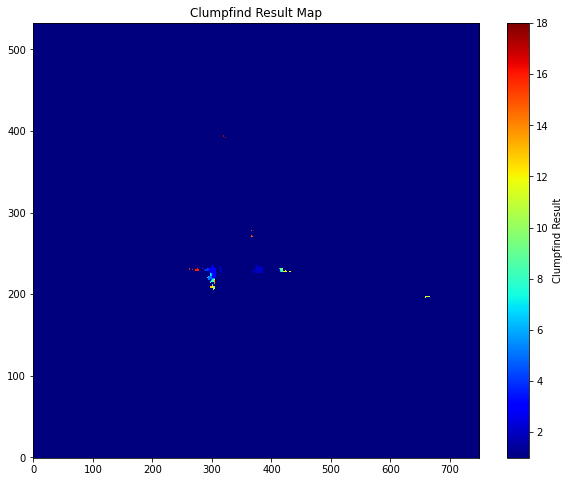

threshold = 1.8
Number of clumps detected at threshold 1.8: 12


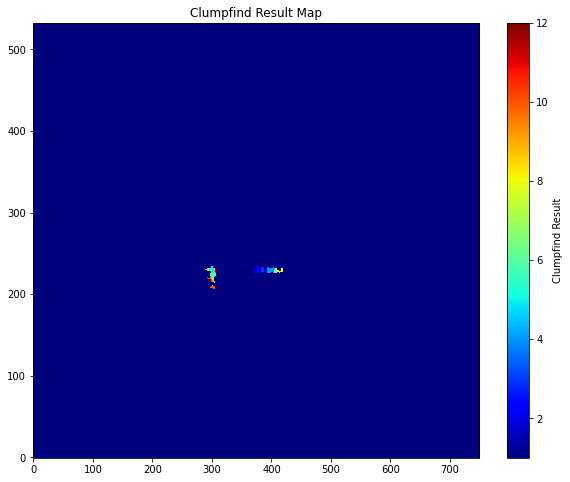

threshold = 2.0
Number of clumps detected at threshold 2.0: 9


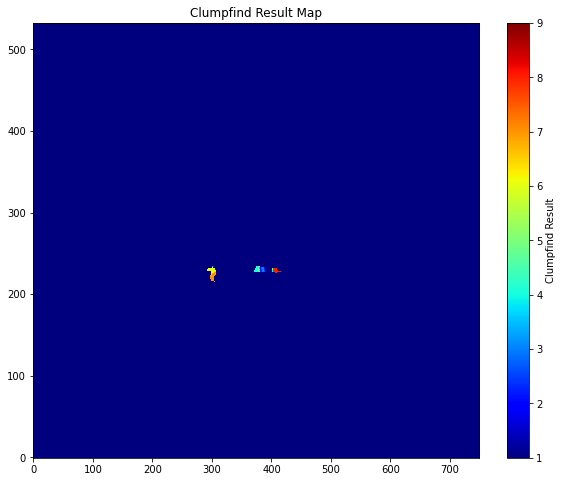

threshold = 2.2
Number of clumps detected at threshold 2.2: 5


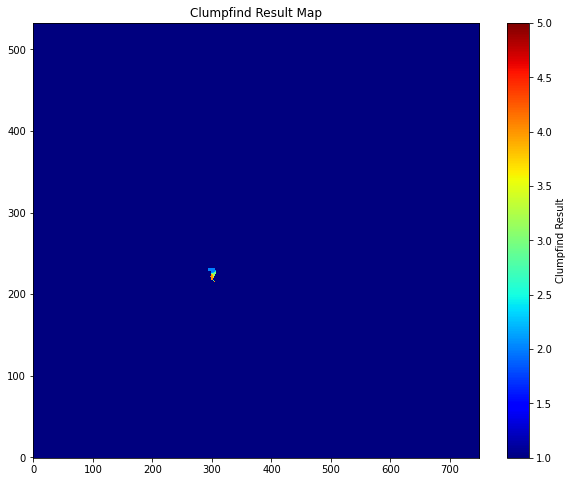

threshold = 2.4
Number of clumps detected at threshold 2.4: 3


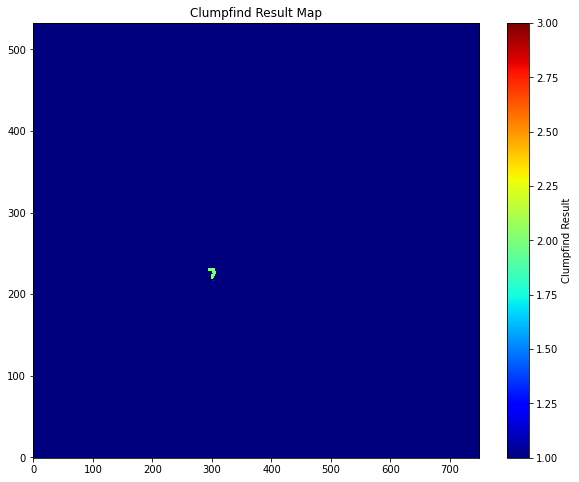

threshold = 2.6
Number of clumps detected at threshold 2.6: 3


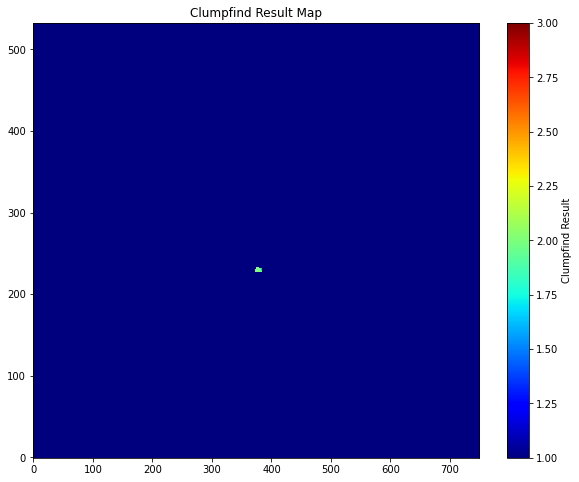

threshold = 2.8
Number of clumps detected at threshold 2.8: 5


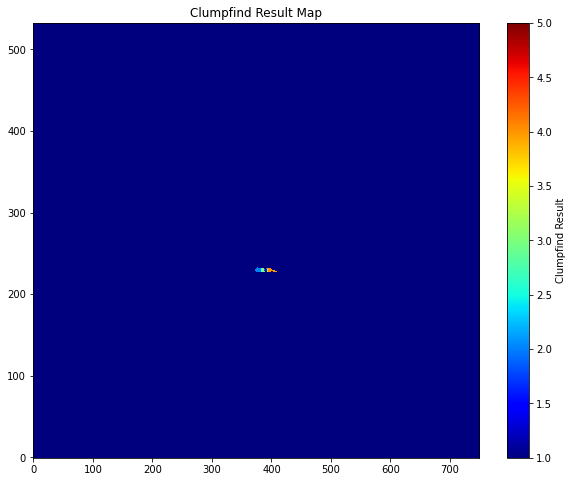

threshold = 3.0
Number of clumps detected at threshold 3.0: 6


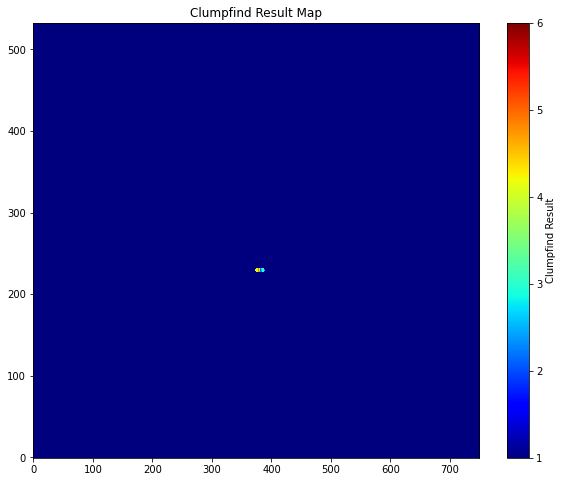

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits


# 加载数据
file_path = '/Users/naoj306/Desktop/clump/diff_data_12CO_x360_5050.fits'  # 替换为你的文件路径
hdu_list = fits.open(file_path)
diff_data = hdu_list[0].data  # 假设数据在第一个HDU中
hdu_list.close()

# 显示图像
plt.figure(figsize=(10, 8))  # 可以调整图像大小
plt.imshow(diff_data.T, origin='lower', cmap='seismic')  # origin='lower' 使得图像的原点在左下角
plt.colorbar()  # 显示颜色条
plt.title('xch_360')
plt.show()


thresholds = [-2, -1, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]  # Absolute value for clump detection
for threshold in thresholds:
    cf_result = clumpfind(diff_data, threshold)
    print(f"threshold = {threshold}")
    if cf_result is not None:
        cf = cf_result.astype("float32")
        cf_2 = cf.reshape(cf.shape[::-1])  # Rearranging for plotting purposes
        unique_clumps = np.unique(cf_result)

        # 计算团块数量
        unique_clumps = np.unique(cf_result)
        unique_clumps = unique_clumps[unique_clumps != 0]  # 排除背景 (通常背景被标记为0)
        print(f"Number of clumps detected at threshold {threshold}: {len(unique_clumps)}")
        
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(cf_2, origin='lower', aspect='auto', cmap='jet', vmin=1, vmax=len(unique_clumps))
        plt.colorbar(im, ax=ax, label='Clumpfind Result')
        plt.title('Clumpfind Result Map')
        
    else:
        print('No Clumps Found')
    plt.show()




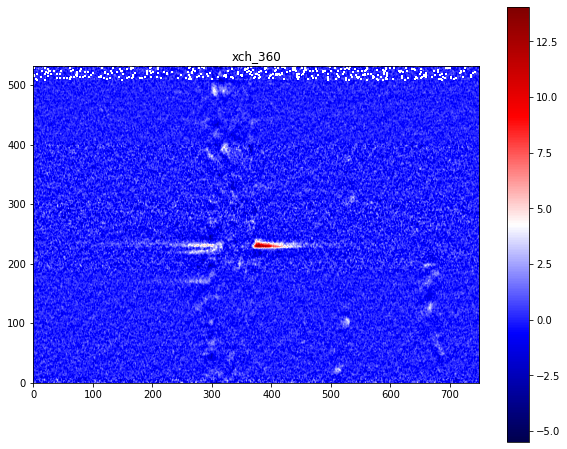

threshold = -2
No Clumps Found
threshold = -1
No Clumps Found
threshold = 0
No Clumps Found
threshold = 0.2
Number of clumps detected at threshold 0.2: 6873


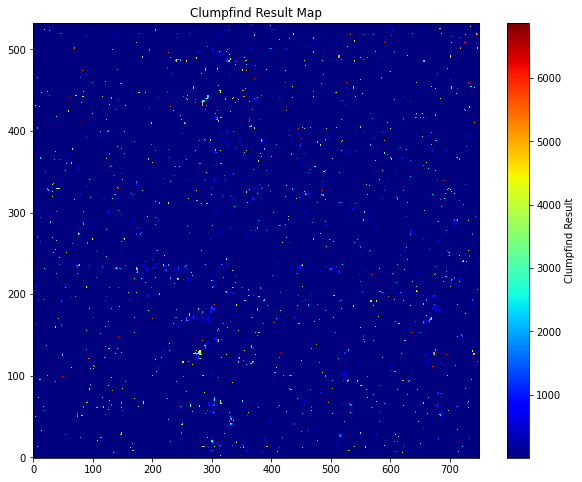

threshold = 0.4
Number of clumps detected at threshold 0.4: 2173


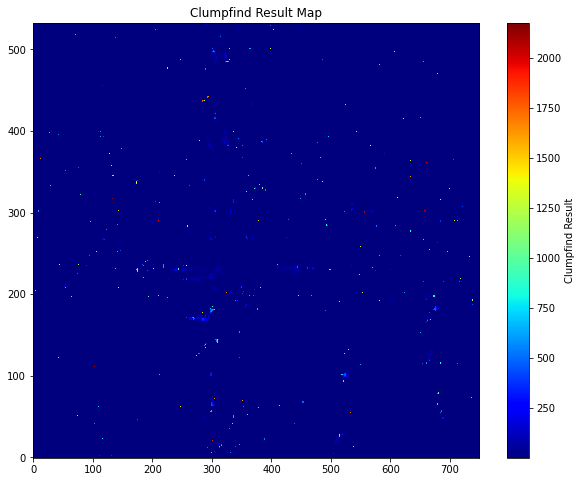

threshold = 0.6
Number of clumps detected at threshold 0.6: 427


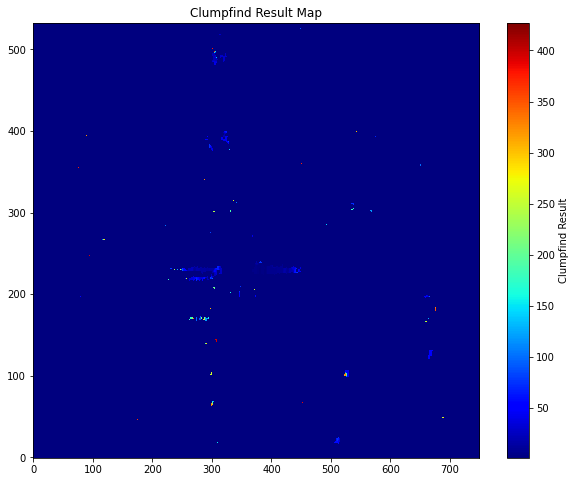

threshold = 0.8
Number of clumps detected at threshold 0.8: 106


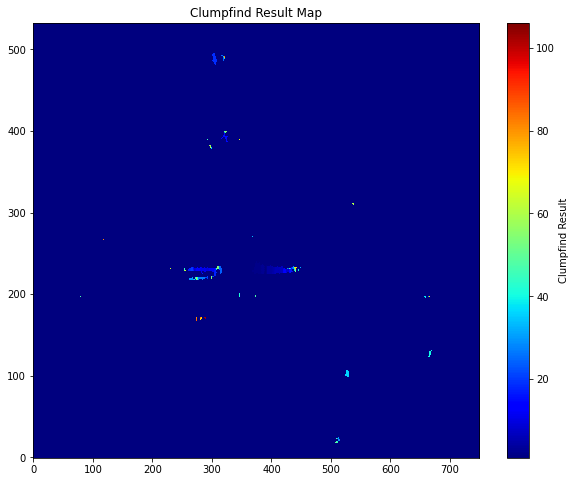

threshold = 1.0
Number of clumps detected at threshold 1.0: 53


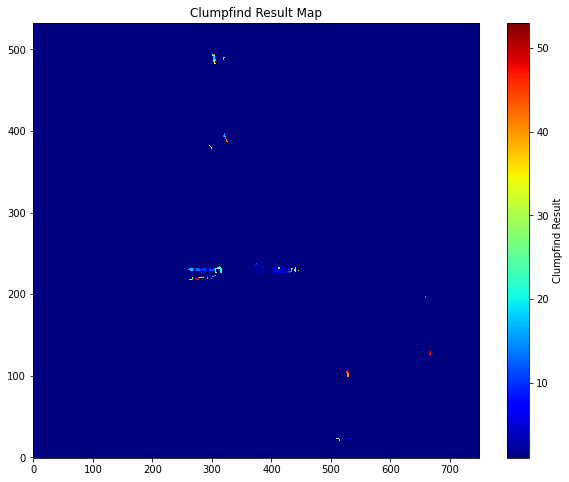

threshold = 1.2
Number of clumps detected at threshold 1.2: 23


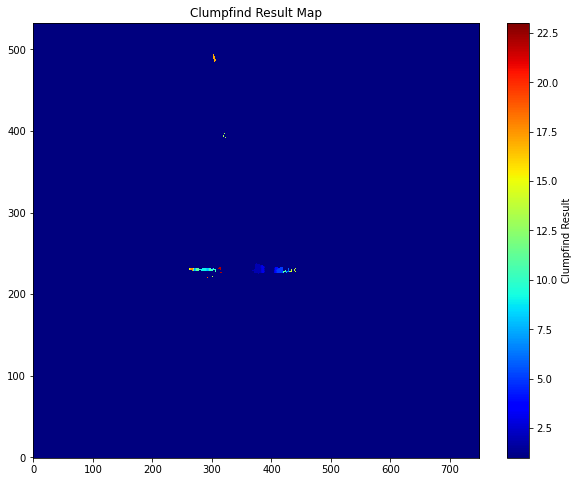

threshold = 1.4
Number of clumps detected at threshold 1.4: 15


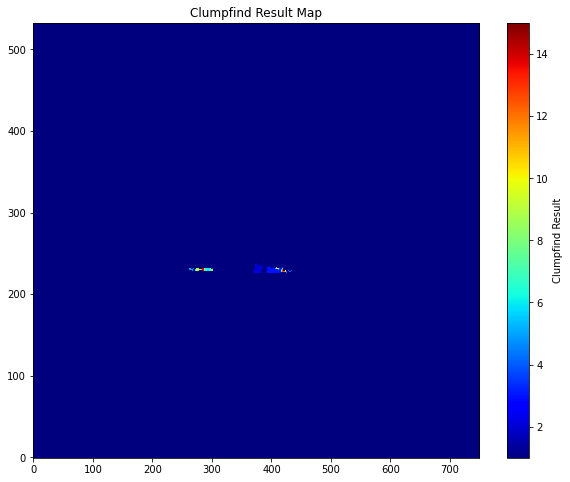

threshold = 1.6
Number of clumps detected at threshold 1.6: 8


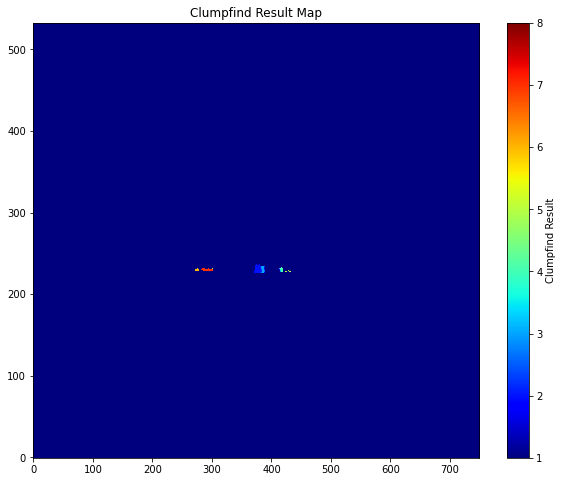

threshold = 1.8
Number of clumps detected at threshold 1.8: 5


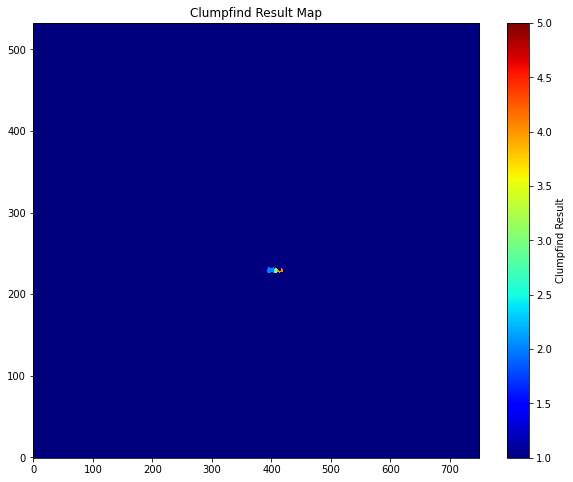

threshold = 2.0
Number of clumps detected at threshold 2.0: 6


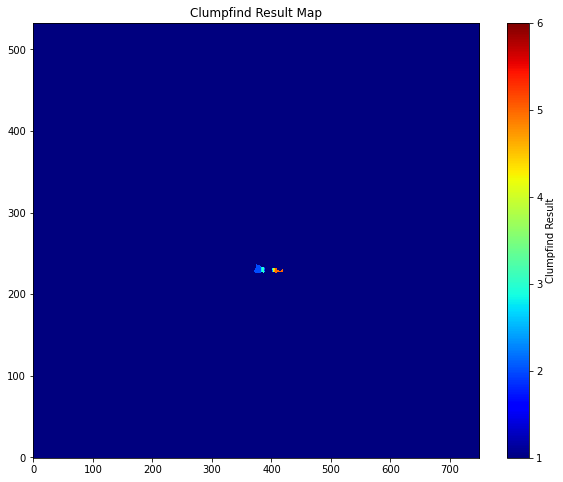

threshold = 2.2
Number of clumps detected at threshold 2.2: 6


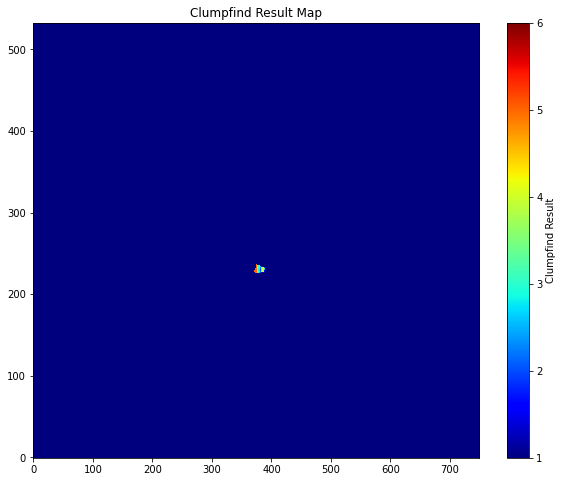

threshold = 2.4
Number of clumps detected at threshold 2.4: 2


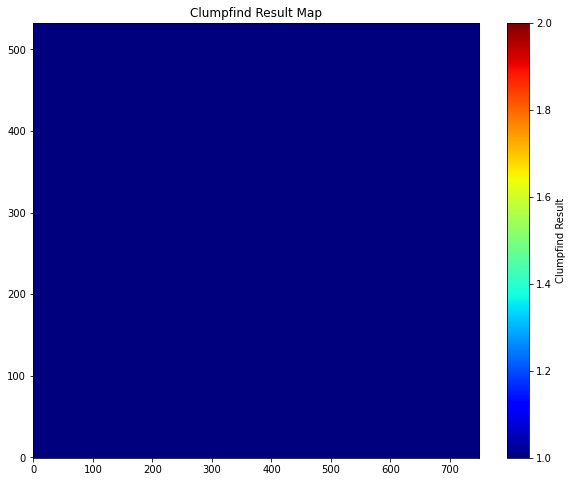

threshold = 2.6
Number of clumps detected at threshold 2.6: 2


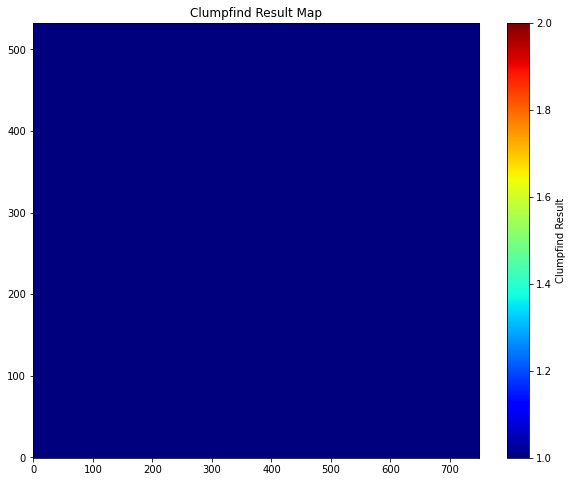

threshold = 2.8
Number of clumps detected at threshold 2.8: 4


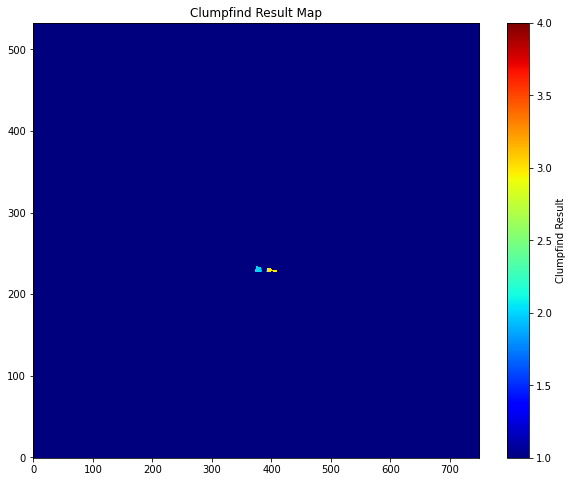

threshold = 3.0
Number of clumps detected at threshold 3.0: 4


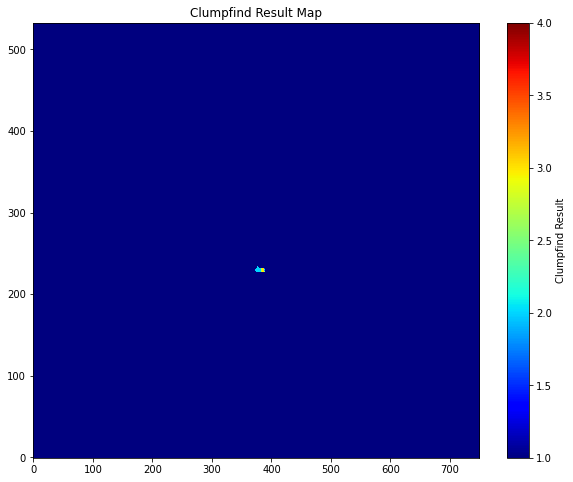

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits


# 加载数据
file_path = '/Users/naoj306/Desktop/clump/diff_data_12CO_x360_0350.fits'  # 替换为你的文件路径
hdu_list = fits.open(file_path)
diff_data = hdu_list[0].data
hdu_list.close()

# 显示图像
plt.figure(figsize=(10, 8))  # 可以调整图像大小
plt.imshow(diff_data.T, origin='lower', cmap='seismic')  # origin='lower' 使得图像的原点在左下角
plt.colorbar()  # 显示颜色条
plt.title('xch_360')
plt.show()


thresholds = [-2, -1, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]   # Absolute value for clump detection
for threshold in thresholds:
    cf_result = clumpfind(diff_data, threshold)
    print(f"threshold = {threshold}")
    if cf_result is not None:
        cf = cf_result.astype("float32")
        cf_2 = cf.reshape(cf.shape[::-1])  # Rearranging for plotting purposes

        # 计算团块数量
        unique_clumps = np.unique(cf_result)
        unique_clumps = unique_clumps[unique_clumps != 0]  # 排除背景 (通常背景被标记为0)
        print(f"Number of clumps detected at threshold {threshold}: {len(unique_clumps)}")
        
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(cf_2, origin='lower', aspect='auto', cmap='jet', vmin=1, vmax=len(unique_clumps))
        plt.colorbar(im, ax=ax, label='Clumpfind Result')
        plt.title('Clumpfind Result Map')
        
    else:
        print('No Clumps Found')
    plt.show()




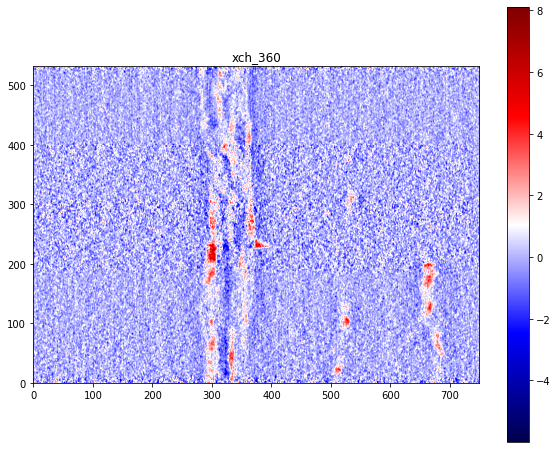

threshold = -2
No Clumps Found
threshold = -1
No Clumps Found
threshold = 0
No Clumps Found
threshold = 0.2
Number of clumps detected at threshold 0.2: 6885


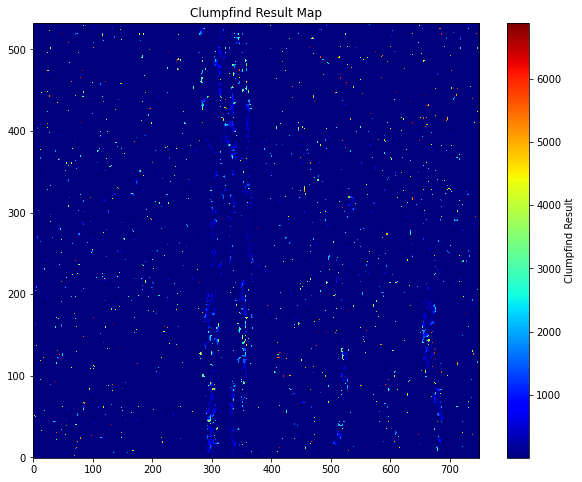

threshold = 0.4
Number of clumps detected at threshold 0.4: 2394


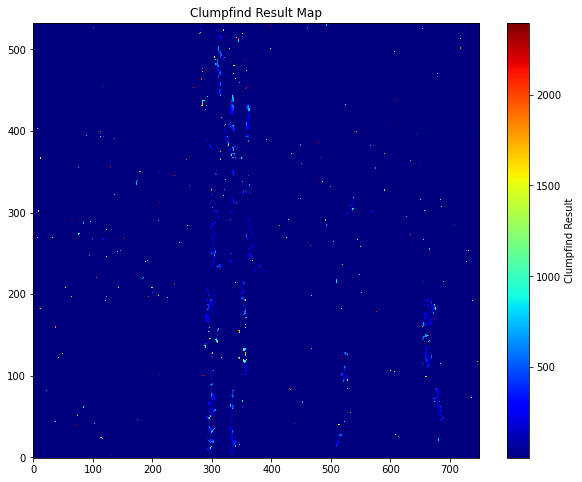

threshold = 0.6
Number of clumps detected at threshold 0.6: 555


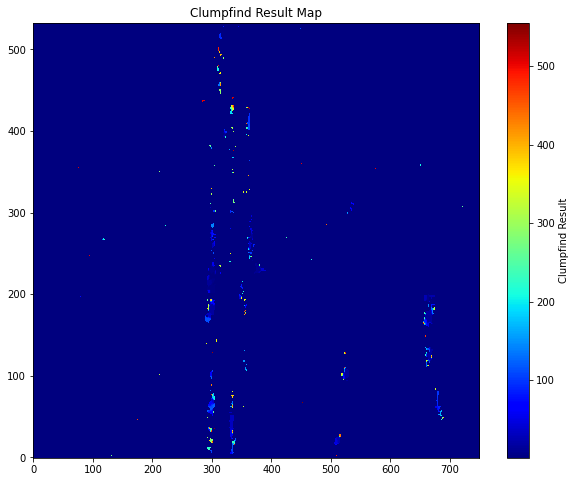

threshold = 0.8
Number of clumps detected at threshold 0.8: 180


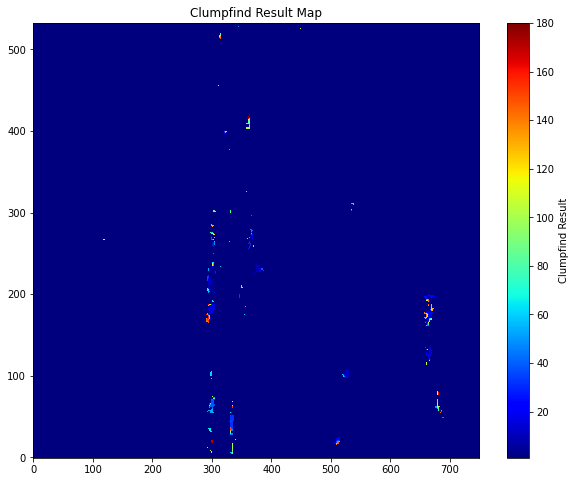

threshold = 1.0
Number of clumps detected at threshold 1.0: 70


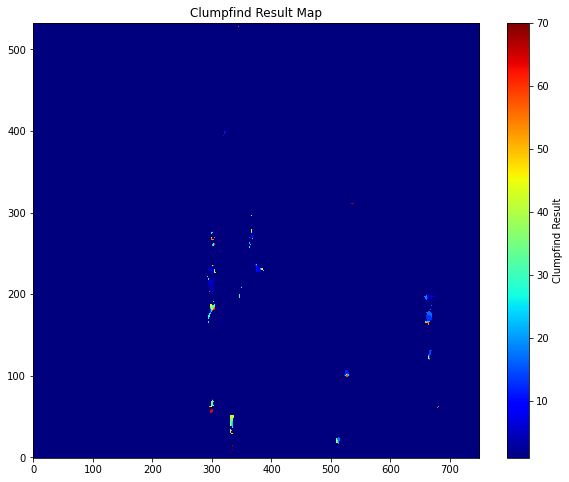

threshold = 1.2
Number of clumps detected at threshold 1.2: 27


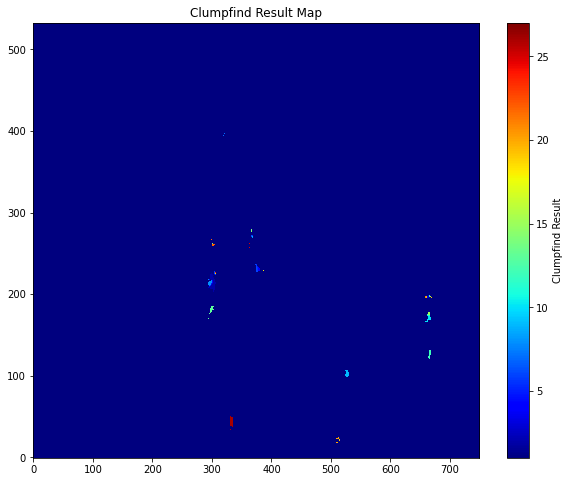

threshold = 1.4
Number of clumps detected at threshold 1.4: 16


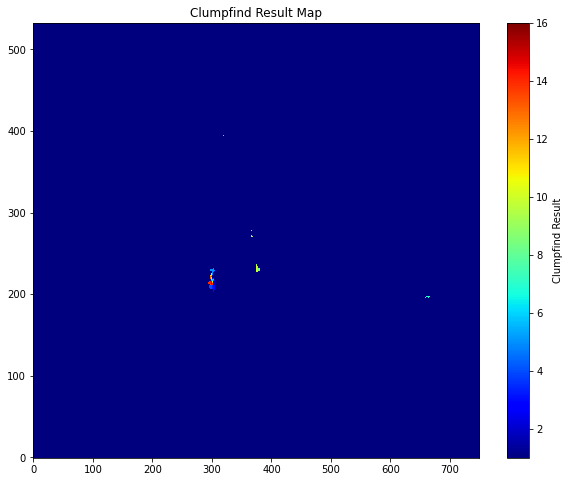

threshold = 1.6
Number of clumps detected at threshold 1.6: 7


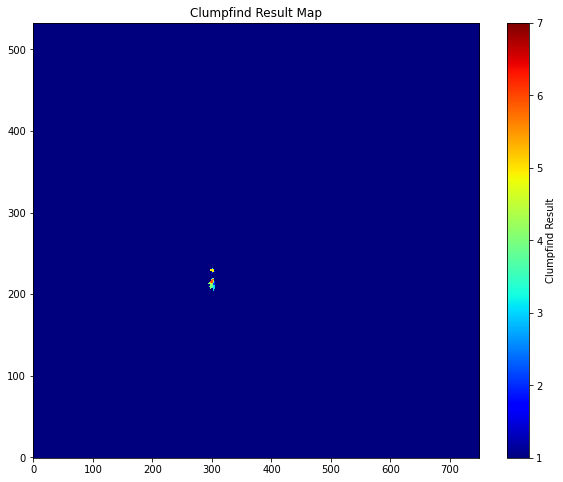

threshold = 1.8
Number of clumps detected at threshold 1.8: 3


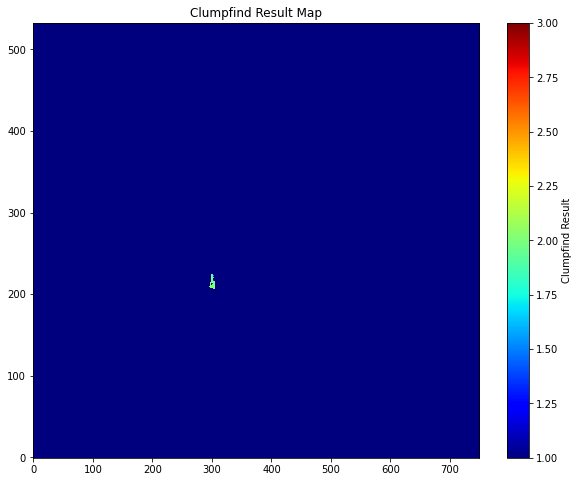

threshold = 2.0
Number of clumps detected at threshold 2.0: 2


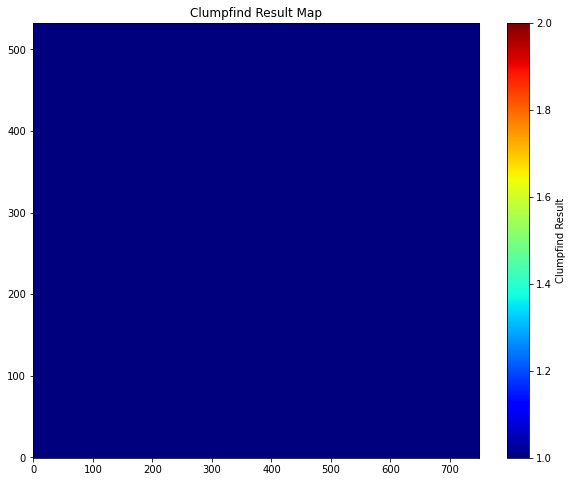

threshold = 2.2
No Clumps Found
threshold = 2.4
No Clumps Found
threshold = 2.6
No Clumps Found
threshold = 2.8
No Clumps Found
threshold = 3.0
No Clumps Found


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits


# 加载数据
file_path = '/Users/naoj306/Desktop/clump/diff_data_12CO_x360_5003.fits'  # 替换为你的文件路径
hdu_list = fits.open(file_path)
diff_data = hdu_list[0].data
hdu_list.close()

# 显示图像
plt.figure(figsize=(10, 8))  # 可以调整图像大小
plt.imshow(diff_data.T, origin='lower', cmap='seismic')  # origin='lower' 使得图像的原点在左下角
plt.colorbar()  # 显示颜色条
plt.title('xch_360')
plt.show()


thresholds = [-2, -1, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]   # Absolute value for clump detection
for threshold in thresholds:
    cf_result = clumpfind(diff_data, threshold)
    print(f"threshold = {threshold}")
    if cf_result is not None:
        cf = cf_result.astype("float32")
        cf_2 = cf.reshape(cf.shape[::-1])  # Rearranging for plotting purposes

        # 计算团块数量
        unique_clumps = np.unique(cf_result)
        unique_clumps = unique_clumps[unique_clumps != 0]  # 排除背景 (通常背景被标记为0)
        print(f"Number of clumps detected at threshold {threshold}: {len(unique_clumps)}")
        
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(cf_2, origin='lower', aspect='auto', cmap='jet', vmin=1, vmax=len(unique_clumps))
        plt.colorbar(im, ax=ax, label='Clumpfind Result')
        plt.title('Clumpfind Result Map')
        
    else:
        print('No Clumps Found')
    plt.show()




In [ ]:
# test